In [2]:
import json
import os
import numpy as np
import pandas as pd
from scipy.interpolate import griddata, RBFInterpolator
from scipy import optimize
from bmn.brezin import compute_Brezin_energy
from scipy import interpolate, integrate

import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5.0
plt.rcParams["xtick.minor.size"] = 3.0
plt.rcParams["ytick.major.size"] = 5.0
plt.rcParams["ytick.minor.size"] = 3.0
plt.rcParams["lines.linewidth"] = 2
plt.rc("font", family="serif", size=16)
matplotlib.rc("text", usetex=True)
matplotlib.rc("legend", fontsize=16)
matplotlib.rcParams["axes.prop_cycle"] = cycler(
    color=["#E24A33", "#348ABD", "#988ED5", "#777777", "#FBC15E", "#8EBA42", "#FFB5B8"]
)
matplotlib.rcParams.update(
    {"axes.grid": True, "grid.alpha": 0.75, "grid.linewidth": 0.5}
)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

np.set_printoptions(linewidth=160)

In [3]:
#DEBUG 21:43:05.445168: Generating quadratic constraints, operator 329/64065
#DEBUG 21:39:02.110695: Generating quadratic constraints, operator 1/64065

#4*60 / 329 * 64065 / 3600 / 24

In [15]:
def load_data(
        datadir,
        names_in_filename,
        tol=1e-6,
        delete_param=True
        ):

    # grab the data files
    names_in_filename.append('.json')
    files = []
    for f in os.listdir(datadir):
        if all(name in f for name in names_in_filename):
            files.append(f)
    print(f"number of files found: {len(files)}")

    if len(files) == 0:
        return

    # build dataframe
    data = []
    for file in files:
        with open(f"{datadir}/{file}") as f:
            result = json.load(f)
        if delete_param:
            del result["param"] # remove param vector
        #result["energy"] = float(file.split('_')[1][:-5]) # add g4 coupling
        result["filename"] = file

        if (
            (np.abs(result["min_bootstrap_eigenvalue"]) < tol) &
            (np.abs(result["violation_of_linear_constraints"]) < tol) &
            (np.abs(result["quad_constraint_violation_norm"]) < tol)
        ):
            data.append(result)

    df = pd.DataFrame(data)
    df.sort_values("energy", inplace=True)

    max_violation_linear = df["violation_of_linear_constraints"].max()
    max_violation_quadratic = df["max_quad_constraint_violation"].max()
    max_violation_PSD = df["min_bootstrap_eigenvalue"].abs().max()

    print(f"number of loaded data points: {len(data)}")
    print(f"max violation of linear constraints:{max_violation_linear:.4e}")
    print(f"max violation of PSD constraints:{max_violation_PSD:.4e}")
    print(f"max violation of quadratic constraints:{max_violation_quadratic:.4e}\n")

    return df.copy()


def Morita_R_squared(d, loop):
    if loop == 2:
        return d / (2 * (d-1)**(1/3))
    elif loop == 3:
        return (d * (148*d - 103)) / (15 * 30**(1/3) * (4*d - 3)**(4/3))


def get_beta_from_E_and_F(energy, free_energy):
    free_energy_interp = interpolate.UnivariateSpline(energy, free_energy)
    dF_by_dE = free_energy_interp.derivative(n=1)
    dF_by_dE = dF_by_dE(energy)
    beta = np.exp(integrate.cumulative_trapezoid(dF_by_dE / (energy - free_energy), energy, initial=0))
    return beta


def lin_lower_bound_x2(energy: float) -> float:
    # eq 2.18 and 2.19 of https://doi.org/10.1007/JHEP06(2023)038
    # includes both bosons and fermions
    # v is an auxiliary variable
    eq2_19 = lambda v: energy**2 + 3**9 / (energy + 3 * v) - 9 * v**2
    sol = optimize.root(eq2_19, [0])
    v = sol.x.item()
    lower_bound = (energy - 3*v)**2 / (9**3 * 16) + 27 / (8 * (energy + 3 * v))
    return lower_bound


def lin_lower_bound_x4_bosonic_only(energy: float, d: int) -> float:
    return energy / (3 * d * (d-1))


def lin_lower_bound_x4_initial(energy: float, d: int) -> float:
    # eq 2.13 of https://doi.org/10.1007/JHEP06(2023)038
    # includes fermions in how the virial theorem is used
    # y is the bound
    eq2_13 = lambda y: np.sqrt(y) * (2*d*(d-1) * y + 2/3*energy) - d/4
    sol = optimize.root(eq2_13, [0])
    return sol.x.item()


def lin_lower_bound_x4_improved(energy: float) -> float:
    # eq 2.20 of https://doi.org/10.1007/JHEP06(2023)038
    # includes both bosons and fermions
    # y is the bound
    eq2_20 = lambda y: (energy/9 + 24*y) * (144 * np.sqrt(y) - (energy/9 - 24*y)**2) - 54
    sol = optimize.root(eq2_20, [0])
    return sol.x.item()


def lin_upper_bound_commutator(energy: float) -> float:
    # TODO in progress!
    # eq 2.23 and 2.24 of https://doi.org/10.1007/JHEP06(2023)038
    # includes both bosons and fermions
    # v is an auxiliary variable
    eq2_24 = lambda v: (energy - 3*v) * (energy + 3*v)**2 - 2*3**9
    eq2_23_RHS = lambda v: (v / 18) * ( 4 * (energy - 3*v)**2/(9**3 * 16) + 27 / (8 * (energy + 3*v))) ** (-2)
    sol = optimize.minimize(eq2_24, [2])
    v = sol.x.item()
    #factor = ( 4 * (energy - 3*v)**2/(9**3 * 16) + 27 / (8 * (energy + 3*v))) ** 2
    #lower_bound = (v / 18) / factor
    return eq2_23_RHS(v)

In [4]:
df_berkowitz = pd.read_csv("data/data_from_papers/Berkowits et al 1606.04951.csv", header=0)

## Miscellaneous

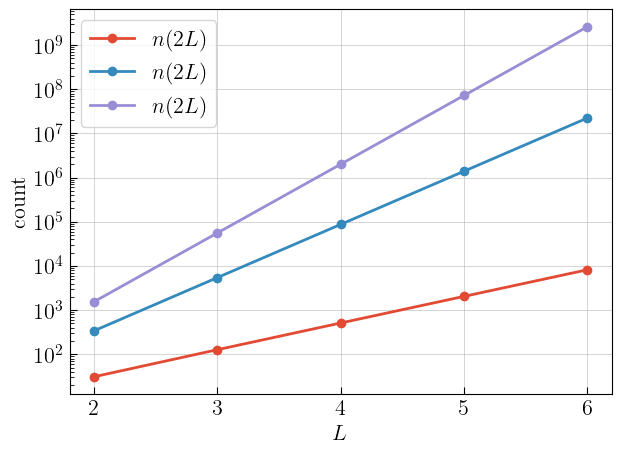

In [6]:
def n(L, d):
    return ((2*d)**(L+1) - 1) / ((2*d) - 1)

L_list = [i for i in range(2, 7)]
d = 2

fig, ax = plt.subplots(figsize=(7, 5))
for idx, d in enumerate(range(1, 4)):
    #ax.plot(L_list, [n(L, d=d)**2 for L in L_list], '--o', label="$n(L)^2$", color=colors[idx])
    ax.plot(L_list, [n(2*L, d=d) for L in L_list], '-o', label="$n(2L)$", color=colors[idx])
ax.set_xlabel(r"$L$")
ax.set_ylabel(r"count")
ax.legend()
#    ax.set_title(f"Growth of operators for d={d}")
ax.set_yscale('log')
plt.show()

## One Matrix

In [7]:
data = []
for L in [3, 4]:
    path =f"data/OneMatrix_L_{L}"
    files = [f for f in os.listdir(path) if ".json" in f]
    print(f"L={L}, number of data points found: {len(files)}")

    for file in files:
        with open(f"{path}/{file}") as f:
            result = json.load(f)
        del result["param"] # remove param vector
        if result["max_quad_constraint_violation"] < 1e-2:
            result["L"] = int(L)
            result["g2"] = float(file.split('_')[1])
            result["g4"] = float(file.split('_')[3])
            result["g6"] = float(file.split('_')[5][:-5])
            data.append(result)

df = pd.DataFrame(data)
df.sort_values("energy", inplace=True)
df.head(10)

L=3, number of data points found: 2280
L=4, number of data points found: 2280


,prob.status,prob.value,maxiters_cvxpy,||x-init||,violation_of_linear_constraints,min_bootstrap_eigenvalue,max_quad_constraint_violation,quad_constraint_violation_norm,tr(1),energy,x_2,x_4,p_2,p_4,L,g2,g4,g6
964,optimal_inaccurate,-80.071457,5000,4.243848e+01,1.699389e-06,-0.001488,7.986823e-03,7.998220e-03,1.000000,-81.861988,8.309350,69.888984,2.271511,9.871535,3,0.0,-14.315789,1.684211
1181,optimal_inaccurate,-55.784329,5000,2.457010e+01,1.103256e-05,-0.001134,4.500354e-03,4.870433e-03,0.999999,-66.868607,7.690975,60.685123,1.903610,6.136557,3,0.0,-13.473684,1.684211
2146,optimal_inaccurate,-48.029528,5000,2.511964e+00,3.609730e-06,-0.002758,1.754759e-03,1.757408e-03,1.000000,-51.693098,7.194083,52.597544,1.912065,6.412466,3,1.0,-12.631579,1.684211
344,optimal_inaccurate,-47.235624,5000,1.164922e-10,1.585036e-06,-0.001550,1.473446e-06,1.580465e-06,1.000000,-48.852075,6.042684,37.430891,1.583670,4.200010,3,0.0,-16.000000,2.526316
1915,optimal_inaccurate,-44.216240,5000,1.397449e-08,1.562710e-06,-0.001457,1.418326e-06,1.558235e-06,1.000000,-45.809548,5.977454,36.641519,1.579988,4.185963,3,1.0,-16.000000,2.526316
1546,optimal_inaccurate,-43.664780,5000,1.300114e-02,4.527502e-07,-0.000316,3.265245e-07,4.514659e-07,1.000000,-44.149468,5.777742,34.274685,1.606177,4.341266,3,-1.0,-15.157895,2.526316
1742,optimal_inaccurate,-40.321391,5000,3.527126e-02,9.077590e-07,-0.000860,8.135393e-07,9.047521e-07,1.000000,-41.258329,5.712723,33.507960,1.601273,4.327206,3,0.0,-15.157895,2.526316
939,optimal_inaccurate,-40.287821,5000,2.709932e+00,7.969546e-07,-0.000314,7.215545e-07,1.293476e-06,1.000000,-41.133168,6.670288,45.383888,1.846626,6.033651,3,1.0,-11.789474,1.684211
446,optimal_inaccurate,-37.388709,5000,8.532095e-03,9.689475e-07,-0.000879,8.452677e-07,9.658834e-07,1.000000,-38.385782,5.644079,32.720383,1.595804,4.311082,3,1.0,-15.157895,2.526316
186,optimal_inaccurate,-36.571455,5000,6.072502e-02,6.276256e-07,-0.000545,5.316807e-07,6.219837e-07,1.000000,-37.226327,5.454895,30.585573,1.620033,4.464430,3,-1.0,-14.315789,2.526316


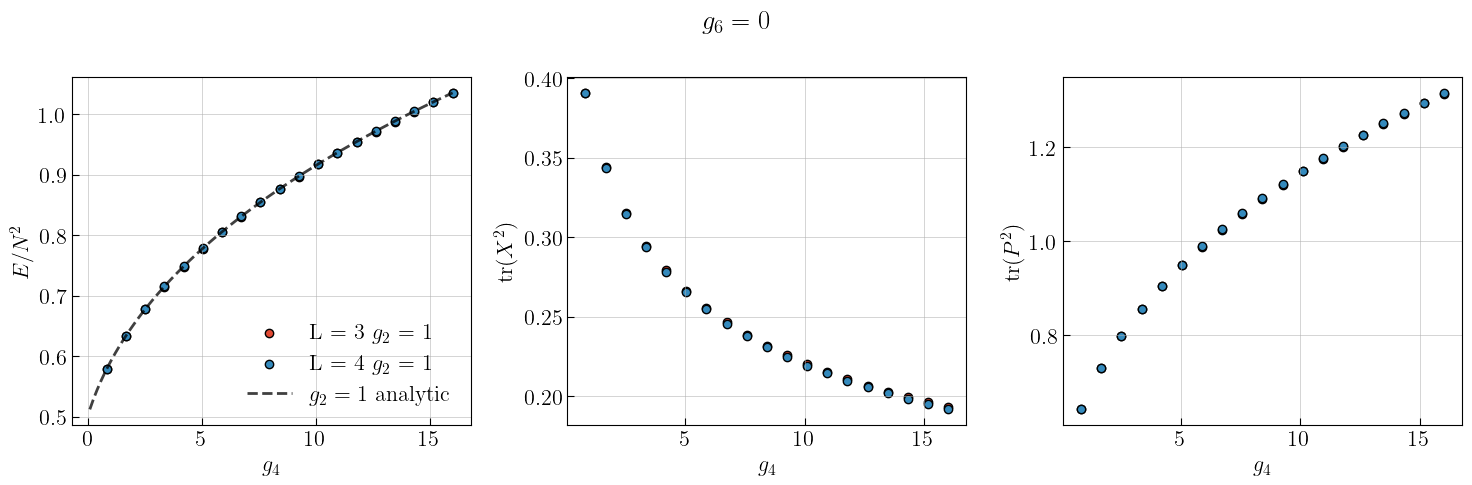

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for L in [3, 4]:
    for g2 in [1]:

        df2 = df[(df["g6"] == 0) & (df["g2"] == g2) & (df["L"] == L)].sort_values("g4")
        g4_max = df2["g4"].max()
        g4_list = np.linspace(0.1, g4_max, 100)

        ax[0].scatter(df2["g4"], df2["energy"], edgecolors="k", label=f"L = {L} " + r"$g_2$ = " + f"{g2}")
        ax[0].set_xlabel(r"$g_4$")
        ax[0].set_ylabel(r"$E/N^2$")

        ax[1].scatter(df2["g4"], df2["x_2"], edgecolors="k")
        ax[1].set_xlabel(r"$g_4$")
        ax[1].set_ylabel(r"tr$(X^2)$")

        ax[2].scatter(df2["g4"], df2["p_2"], edgecolors="k")
        ax[2].set_xlabel(r"$g_4$")
        ax[2].set_ylabel(r"tr$(P^2)$")

ax[0].plot(
    g4_list,
    [compute_Brezin_energy(g/4) for g in g4_list],
    '--',
    color='k',
    alpha=0.75,
    label=r"$g_2 = 1$ analytic"
    )

#[ax[i].set_xlim([0, 1.02 * g4_max]) for i in range(3)]
ax[0].legend(frameon=False)
plt.suptitle(r"$g_6 = 0$")
plt.tight_layout()
plt.show()

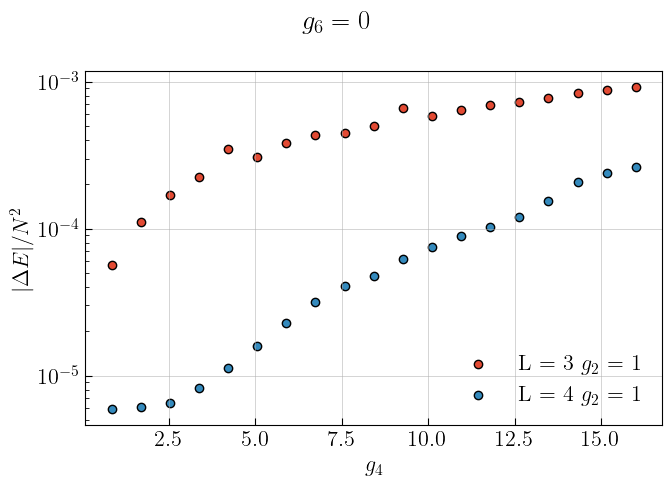

In [9]:
fig, ax = plt.subplots(figsize=(7, 5))

for L in [3, 4]:
    df2 = df[(df["g6"] == 0) & (df["g2"] == 1) & (df["L"] == L)].sort_values("g4")
    Brezin_energy = np.asarray([compute_Brezin_energy(g/4) for g in df2["g4"]])
    ax.scatter(df2["g4"], np.abs(Brezin_energy - df2["energy"]), edgecolors="k", label=f"L = {L} " + r"$g_2$ = " + f"{g2}")

ax.set_xlabel(r"$g_4$")
ax.set_ylabel(r"$|\Delta E|/N^2$")
ax.legend(frameon=False)
ax.set_yscale('log')
plt.suptitle(r"$g_6 = 0$")
plt.tight_layout()
plt.show()

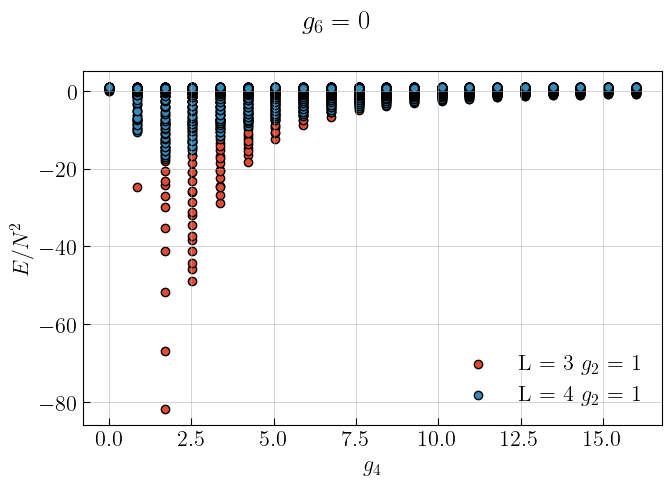

In [10]:
fig, ax = plt.subplots(figsize=(7, 5))

for L in [3, 4]:
    df2 = df[(df["L"] == L)].sort_values("g4")
    ax.scatter(df2["g6"], df2["energy"], edgecolors="k", label=f"L = {L} " + r"$g_2$ = " + f"{g2}")

ax.set_xlabel(r"$g_4$")
ax.set_ylabel(r"$E/N^2$")
ax.legend(frameon=False)
plt.suptitle(r"$g_6 = 0$")
plt.tight_layout()
plt.show()

In [11]:
df2 = df[(df["g2"] == 0) & (df["L"] == 3) & (df["g4"] < 3)]

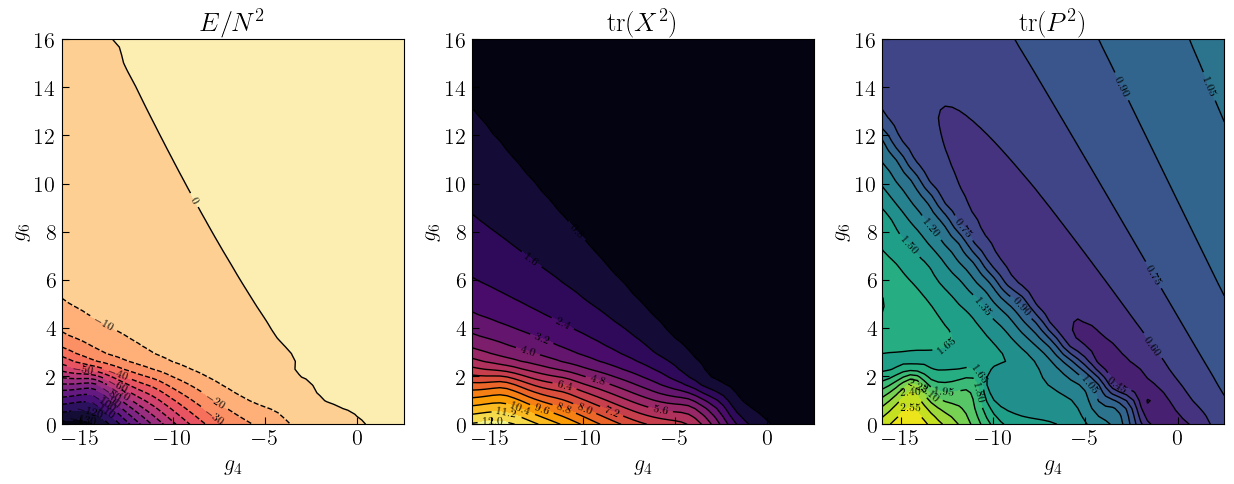

In [12]:
# Extracting x, y, z values
x = df2['g4'].values
y = df2['g6'].values

# Create grid values for x and y
xi = np.linspace(min(x), max(x), 50)
yi = np.linspace(min(y), max(y), 50)
xi, yi = np.meshgrid(xi, yi)

# Create the contour plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
[ax[i].grid(False) for i in range(3)]

# Interpolate z values on the grid
z = df2['energy'].values
rbf = RBFInterpolator(np.column_stack((x, y)), z, kernel='thin_plate_spline')
zi = rbf(np.column_stack((xi.ravel(), yi.ravel()))).reshape(xi.shape)
contour = ax[0].contourf(xi, yi, zi, levels=15, cmap='magma')
contour_lines = ax[0].contour(xi, yi, zi, levels=15, colors='black', linewidths=1)
ax[0].clabel(contour_lines, inline=True, fontsize=8)
#ax[0].colorbar(contour)
ax[0].set_xlabel(r"$g_4$")
ax[0].set_ylabel(r"$g_6$")
ax[0].set_title(r"$E/N^2$")

z = df2['x_2'].values
rbf = RBFInterpolator(np.column_stack((x, y)), z, kernel='thin_plate_spline')
zi = rbf(np.column_stack((xi.ravel(), yi.ravel()))).reshape(xi.shape)
contour = ax[1].contourf(xi, yi, zi, levels=15, cmap='inferno')
contour_lines = ax[1].contour(xi, yi, zi, levels=15, colors='black', linewidths=1)
ax[1].clabel(contour_lines, inline=True, fontsize=8)
ax[1].set_xlabel(r"$g_4$")
ax[1].set_ylabel(r"$g_6$")
ax[1].set_title(r"tr$(X^2)$")

z = df2['p_2'].values
rbf = RBFInterpolator(np.column_stack((x, y)), z, kernel='thin_plate_spline')
zi = rbf(np.column_stack((xi.ravel(), yi.ravel()))).reshape(xi.shape)
contour = ax[2].contourf(xi, yi, zi, levels=15, cmap='viridis')
contour_lines = ax[2].contour(xi, yi, zi, levels=15, colors='black', linewidths=1)
ax[2].clabel(contour_lines, inline=True, fontsize=8)
ax[2].set_xlabel(r"$g_4$")
ax[2].set_ylabel(r"$g_6$")
ax[2].set_title(r"tr$(P^2)$")

plt.show()

## Two Matrix

Case with $m=1$, should match Han et al

number of files found: 101
number of loaded data points: 101
max violation of linear constraints:2.4957e-09
max violation of PSD constraints:5.6036e-07
max violation of quadratic constraints:9.6169e-08

number of files found: 18
number of loaded data points: 13
max violation of linear constraints:3.9720e-06
max violation of PSD constraints:8.9600e-03
max violation of quadratic constraints:8.7022e-05



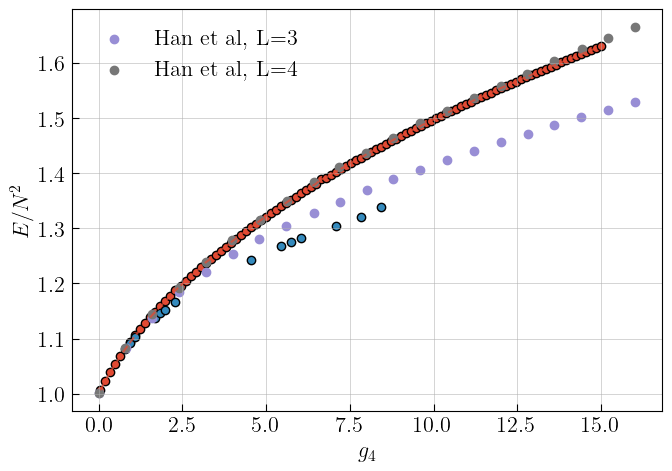

In [4]:
fig, ax = plt.subplots(figsize=(7, 5))

datadir = "data/TwoMatrix_L_3_symmetric"
df = load_data(datadir, names_in_filename=["g4_"])
df["g4"] = [float(df["filename"].iloc[i].split("_")[1][:-5]) for i in range(len(df))]
df.sort_values(by="g4", inplace=True)
ax.scatter(df["g4"], df["energy"], edgecolors="k")
ax.plot(df["g4"], df["energy"], '--', linewidth=1.5, alpha=0.75)

datadir = "data/TwoMatrix_L_3_symmetric_no_penalty"
df = load_data(datadir, names_in_filename=["g4_"], tol=1e-4)
df["g4"] = [float(df["filename"].iloc[i].split("_")[1][:-5]) for i in range(len(df))]
ax.scatter(df["g4"], df["energy"], edgecolors="k")
#ax.plot(df["g4"], df["energy"], '--', linewidth=1.5, alpha=0.75)

df_han_hartnoll_fig3a = pd.read_csv("data/data_from_papers/han_hartnoll_data/TwoMatrixFig3a_L_3.csv", header=None, names=["x", "y"])
ax.scatter(2 * df_han_hartnoll_fig3a["x"], 0.5 * df_han_hartnoll_fig3a["y"], label="Han et al, L=3")

df_han_hartnoll_fig3a = pd.read_csv("data/data_from_papers/han_hartnoll_data/TwoMatrixFig3a_L_4.csv", header=None, names=["x", "y"])
ax.scatter(2 * df_han_hartnoll_fig3a["x"], 0.5 * df_han_hartnoll_fig3a["y"], label="Han et al, L=4")

ax.set_xlabel(r"$g_4$")
ax.set_ylabel(r"$E/N^2$")
ax.legend(frameon=False)
plt.tight_layout()
#ax.set_xlim([0.1, 1.4])
plt.show()

incrementally decreasing E

In [4]:
datadir = "data/TwoMatrix_L_3_symmetric_zero_mass_init_from_previous_soln"
df = load_data(datadir=datadir, names_in_filename=["x_2"], delete_param=False, tol=1e-6)

params = np.asarray([df.iloc[i]["param"] for i in range(len(df))])
zeros = np.abs(params) < 1e-8

for i in range(len(zeros)):
    if not np.all(zeros[i] == zeros[-1]):
        print(i)

number of files found: 30
number of loaded data points: 24
max violation of linear constraints:5.2456e-09
max violation of PSD constraints:1.5950e-06
max violation of quadratic constraints:9.5320e-08



In [5]:
np.round(params[0], decimals=6)

array([ -2.54224 ,  -3.460605,   7.300445,   0.      ,   0.      , -12.574757,  -1.566122,  -0.      ,  -0.      ,  -0.      ,  -0.      ,  -0.429753,
        -6.733438,   0.      ,  -0.      ,  -3.978911,  -0.043002,  -3.261466,  -2.097531,   0.      ,   0.      ,  -5.562625,   1.929844,   0.      ,
        -0.      ,  -0.      ,   0.      ,   5.227262,   3.792596,  -0.      ,  -0.      ,   3.54091 ,   0.727693,  -1.549255,  -1.464399,   0.      ,
         0.      ,   0.439159,   2.843697,  -0.      ,   0.      ,   0.      ,   0.      ,  -5.075614,  -0.685756,  -0.      , -11.089085,   0.444726,
        -4.239411,   2.623129,   5.215249,   2.013621,  -5.935842,   1.322225,  -0.906844,   1.052525,   5.06277 ,   7.474655,  -2.097695,   4.493612,
        -1.053849,   3.436665,  -4.467539,   9.143639,  -7.562561,  -1.614443,   6.267184,  -4.725711, -12.833427,  11.833654,  -9.035897])

In [6]:
np.round(params[1], decimals=6)

array([-2.54224 , -3.342592,  2.571321,  0.      ,  0.      , -3.154731, -2.359066, -0.      , -0.      ,  0.      , -0.      , -0.374678, -2.233227,
        0.      , -0.      , -0.520793, -0.610299, -2.507656, -0.56439 , -0.      , -0.      , -1.326288, -0.847716, -0.      ,  0.      ,  0.      ,
       -0.      ,  1.828418,  1.257614,  0.      ,  0.      ,  1.387531,  0.922026, -0.140334, -0.700627, -0.      , -0.      ,  0.173829,  0.295337,
       -0.      ,  0.      ,  0.      , -0.      , -1.78065 , -0.208734,  0.      , -3.649143, -1.056142, -1.866502,  1.645277,  0.828787,  1.002647,
       -2.124895,  0.348857, -0.794919, -0.110759,  1.652311,  3.041752, -2.413665,  1.647015, -0.307402,  1.483791, -1.874348,  2.582076, -1.851588,
       -1.317829,  1.486618, -1.679955, -3.895109,  2.523741, -1.676304])

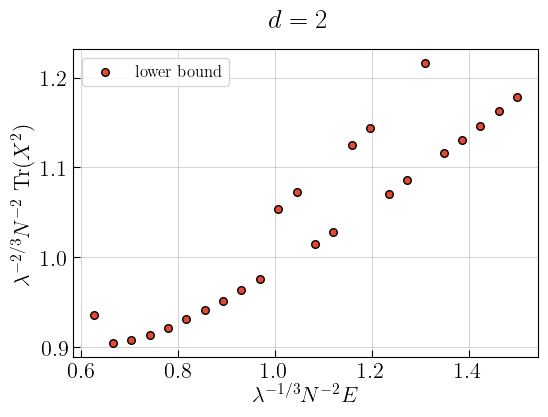

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))

operator_to_minimize = "x_2"
#df_tmp = df[(df["operator_to_minimize"] == operator_to_minimize)]
ax.scatter(df["energy"], df[operator_to_minimize], edgecolor='k', zorder=10, s=30, label='lower bound')

# Reference lines
#ax.axvline(0.7, linestyle='--', color=colors[2], linewidth=1.5, label='Min. energy, Morita')
#ax.axvline(0.7568, linestyle='--', color='k', linewidth=1.5, label='Min. energy, me')
#ax.axhline(2*Morita_R_squared(d=2, loop=2), linestyle='--', color='k', linewidth=1.5, label='T=0 2*R2 (2 loop)')
#ax.axhline(2*Morita_R_squared(d=2, loop=3), linestyle='--', color='k', linewidth=1.5, label='T=0 2*R2 (3 loop)')

ax.legend(fontsize=12)
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"$\lambda^{-2/3} N^{-2}$ Tr$(X^2)$")

plt.suptitle(r"$d=2$")
plt.show()

Case with $m=0$, can be thought of as a $d=2$ version of Mini-BFSS.

In [30]:
## max_quad_constraint_violation no longer being computed correctly
tol = 1e-4

dataframes = []
for method in ["pytorch", "cvxpy"]:
    for L in [3, 4]:
        datadir = f"data/TwoMatrix_L_{L}_symmetric_energy_fixed_g2_0"
        if method == "pytorch":
            datadir += "_pytorch"
        #datadir = f"data/TwoMatrix_L_{L}_symmetric_energy_fixed_g2_0_no_penalty"
        #datadir = f"data/TwoMatrix_L_{L}_symmetric_energy_fixed_g2_0_pytorch"

        df = load_data(
            datadir=datadir,
            names_in_filename=['energy', "min_x_2"],
            tol=tol,
        )
        if df is not None:
            df["operator_to_minimize"] = "x_2"
            df["L"] = L
            df["method"] = method
            dataframes.append(df)

        df = load_data(
            datadir=datadir,
            names_in_filename=['energy', "neg_x_2"],
            tol=tol,
        )
        if df is not None:
            df["operator_to_minimize"] = "neg_x_2"
            df["L"] = L
            df["method"] = method
            dataframes.append(df)

        df = load_data(
            datadir=datadir,
            names_in_filename=['energy', "x_4"],
            tol=tol,
        )
        if df is not None:
            df["operator_to_minimize"] = "x_4"
            df["L"] = L
            df["method"] = method
            dataframes.append(df)

df = pd.concat(dataframes)
df.tail(5)

number of files found: 25
number of loaded data points: 13
max violation of linear constraints:0.0000e+00
max violation of PSD constraints:1.6420e-07
max violation of quadratic constraints:1.2807e-07

number of files found: 24
number of loaded data points: 16
max violation of linear constraints:0.0000e+00
max violation of PSD constraints:1.6992e-07
max violation of quadratic constraints:1.1020e-08

number of files found: 25
number of loaded data points: 14
max violation of linear constraints:0.0000e+00
max violation of PSD constraints:9.7457e-08
max violation of quadratic constraints:7.2325e-07

number of files found: 25
number of loaded data points: 15
max violation of linear constraints:0.0000e+00
max violation of PSD constraints:2.6956e-06
max violation of quadratic constraints:9.5493e+02

number of files found: 22
number of loaded data points: 17
max violation of linear constraints:0.0000e+00
max violation of PSD constraints:3.2335e-06
max violation of quadratic constraints:8.6660e

/tmp/ipykernel_38596/2420352859.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dataframes)


,solver,num_epochs,operator_loss,violation_of_linear_constraints,min_bootstrap_eigenvalue,quad_constraint_violation_norm,max_quad_constraint_violation,tr(1),energy,x_2,...,filename,operator_to_minimize,L,method,lagrangian,prob.status,prob.value,maxiters_cvxpy,||x-init||,PRNG_seed
1,SCS,NaN,NaN,2.560183e-07,-3.139378e-08,2.562762e-07,1.705793e-07,1.0,0.872414,2.704664,...,energy_0.872414_op_to_min_neg_x_2.json,neg_x_2,4,cvxpy,0.290805,optimal_inaccurate,-2.434714,10000.0,0.003571,NaN
3,SCS,NaN,NaN,3.188711e-08,-8.341210e-07,3.284776e-08,2.263889e-08,1.0,0.824138,1.374068,...,energy_0.824138_op_to_min_x_4.json,x_4,4,cvxpy,0.274713,optimal_inaccurate,1.999980,10000.0,0.008438,NaN
1,SCS,NaN,NaN,1.115979e-08,-4.252167e-07,3.339539e-08,2.148395e-08,1.0,1.162069,1.480960,...,energy_1.162069_op_to_min_x_4.json,x_4,4,cvxpy,NaN,optimal_inaccurate,2.215768,10000.0,0.020338,NaN
0,SCS,NaN,NaN,1.211453e-08,-4.409249e-07,2.998240e-08,1.813950e-08,1.0,1.258621,1.518970,...,energy_1.258621_op_to_min_x_4.json,x_4,4,cvxpy,0.419540,optimal_inaccurate,2.304322,10000.0,0.017910,NaN
2,SCS,NaN,NaN,1.160916e-08,-3.411368e-07,1.438973e-08,8.554522e-09,1.0,1.306897,1.539163,...,energy_1.306897_op_to_min_x_4.json,x_4,4,cvxpy,0.435632,optimal_inaccurate,2.350286,10000.0,0.009946,NaN


In [26]:
len(df[df["L"] == 3]), len(df[df["L"] == 4])

(207, 9)

In [31]:
# test that H = K + V, implying that K, V can be correctly extracted
assert np.allclose(df["energy"], df["p_2"]/2 + df["neg_commutator_squared"]/4)

df["energy"] = np.round(df["energy"], decimals=8)
df.sort_values("energy", inplace=True)

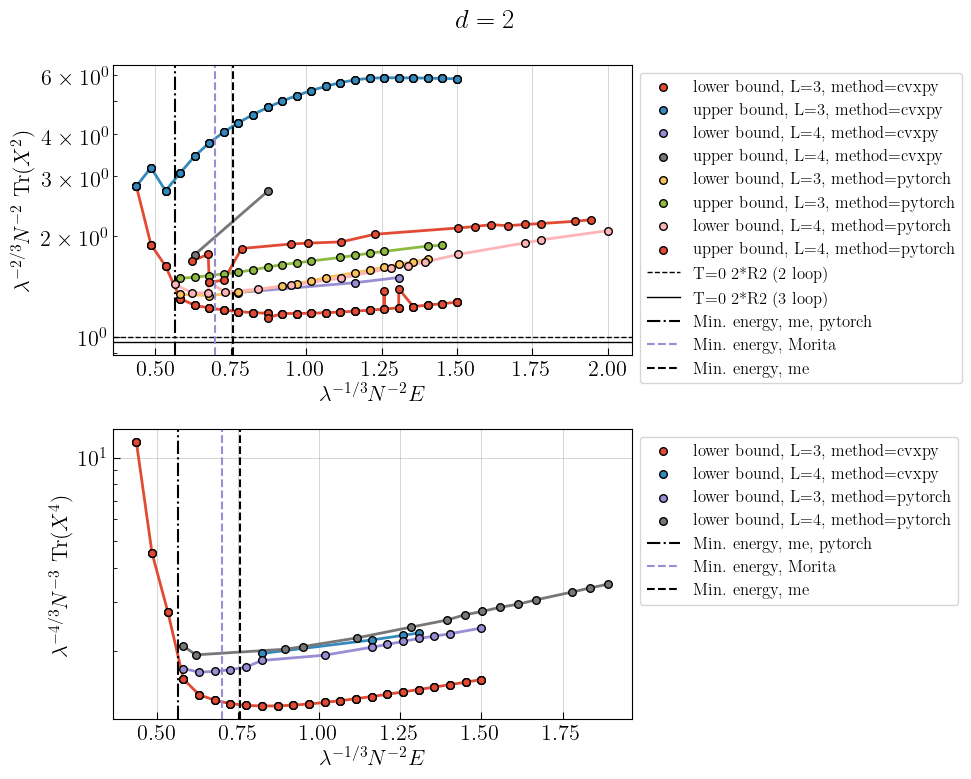

In [38]:
fig, axes = plt.subplots(2, 1, figsize=(10, 2*4))

ax = axes[0]
for method in ["cvxpy", "pytorch"]:
    for L in [3, 4]:
        operator_to_minimize = "x_2"
        df_tmp = df[(df["operator_to_minimize"] == operator_to_minimize) & (df["L"] == L) & (df["method"] == method)]
        if len(df_tmp) > 0:
            ax.scatter(df_tmp["energy"], df_tmp[operator_to_minimize], edgecolor='k', zorder=10, s=30, label=f'lower bound, L={L}, method={method}')
            ax.plot(df_tmp["energy"], df_tmp[operator_to_minimize])

        operator_to_minimize = "neg_x_2"
        df_tmp = df[(df["operator_to_minimize"] == operator_to_minimize) & (df["L"] == L) & (df["method"] == method)]
        if len(df_tmp) > 0:
            ax.scatter(df_tmp["energy"], df_tmp["x_2"], edgecolor='k', zorder=10, s=30, label=f'upper bound, L={L}, method={method}')
            ax.plot(df_tmp["energy"], df_tmp["x_2"])
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"$\lambda^{-2/3} N^{-2}$ Tr$(X^2)$")
ax.axhline(Morita_R_squared(d=2, loop=2), linestyle='--', color='k', linewidth=1, label='T=0 2*R2 (2 loop)')
ax.axhline(Morita_R_squared(d=2, loop=3), linestyle='-', color='k', linewidth=1, label='T=0 2*R2 (3 loop)')
ax.set_yscale('log')

ax = axes[1]
for method in ["cvxpy", "pytorch"]:
    for L in [3, 4]:
        operator_to_minimize = "x_4"
        df_tmp = df[(df["operator_to_minimize"] == operator_to_minimize) & (df["L"] == L) & (df["method"] == method)]
        if len(df_tmp) > 0:
            ax.scatter(df_tmp["energy"], df_tmp[operator_to_minimize], edgecolor='k', zorder=10, s=30, label=f'lower bound, L={L}, method={method}')
            ax.plot(df_tmp["energy"], df_tmp[operator_to_minimize])
ax.legend(fontsize=12, bbox_to_anchor=(1,1))
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"$\lambda^{-4/3} N^{-3}$ Tr$(X^4)$")
ax.set_yscale('log')

for ax in axes:
    ax.axvline(0.5662, linestyle='-.', color='k', linewidth=1.5, label='Min. energy, me, pytorch')
    ax.axvline(0.7, linestyle='--', color=colors[2], linewidth=1.5, label='Min. energy, Morita')
    ax.axvline(0.7568, linestyle='--', color='k', linewidth=1.5, label='Min. energy, me')
    ax.legend(fontsize=12, bbox_to_anchor=(1,1))

plt.suptitle(r"$d=2$")
plt.tight_layout()
plt.show()

## BFSS

In [13]:
datadir = "data/MiniBFSS_L_3_symmetric"
tol = 1e-7

df_x2 = load_data(
    datadir=datadir,
    names_in_filename=['energy', "min_x_2"],
    tol=tol,
)
df_x2["operator_to_minimize"] = "x_2"


df_neg_x2 = load_data(
    datadir=datadir,
    names_in_filename=['energy', "neg_x_2"],
    tol=tol,
)
df_neg_x2["operator_to_minimize"] = "neg_x_2"


df_x4 = load_data(
    datadir=datadir,
    names_in_filename=['energy', "x_4"],
    tol=tol,
)
df_x4["operator_to_minimize"] = "x_4"


df = pd.concat([df_x2, df_neg_x2, df_x4])

# test that H = K + V, implying that K, V can be correctly extracted
assert np.allclose(df["energy"], df["p_2"]/2 + df["neg_commutator_squared"]/4)

df["energy"] = np.round(df["energy"], decimals=8)
df.sort_values("energy", inplace=True)

number of files found: 30
number of loaded data points: 23
max violation of linear constraints:1.4167e-07
max violation of PSD constraints:3.2010e-06
max violation of quadratic constraints:9.4491e-08

number of files found: 30
number of loaded data points: 16
max violation of linear constraints:1.3492e-07
max violation of PSD constraints:4.9115e-06
max violation of quadratic constraints:9.9437e-08

number of files found: 30
number of loaded data points: 22
max violation of linear constraints:2.1902e-08
max violation of PSD constraints:5.7713e-07
max violation of quadratic constraints:1.4483e-08



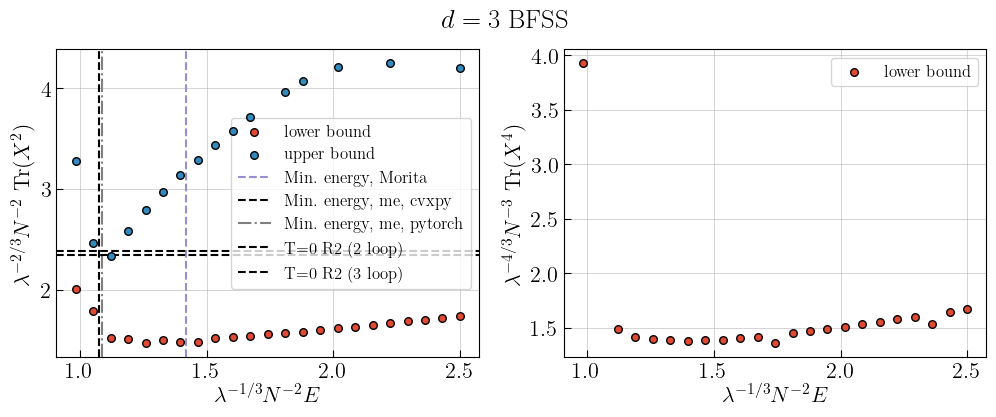

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(2*6, 4))

ax = axes[0]

operator_to_minimize = "x_2"
df_tmp = df[(df["operator_to_minimize"] == operator_to_minimize)]
ax.scatter(df_tmp["energy"], df_tmp[operator_to_minimize], edgecolor='k', zorder=10, s=30, label='lower bound')

operator_to_minimize = "neg_x_2"
df_tmp = df[(df["operator_to_minimize"] == operator_to_minimize)]
ax.scatter(df_tmp["energy"], -df_tmp[operator_to_minimize], edgecolor='k', zorder=10, s=30, label='upper bound')

ax.axvline(1.42, linestyle='--', color=colors[2], linewidth=1.5, label='Min. energy, Morita')
ax.axvline(1.0763, linestyle='--', color='k', linewidth=1.5, label='Min. energy, me, cvxpy')
ax.axvline(1.0875, linestyle='-.', color='gray', linewidth=1.5, label='Min. energy, me, pytorch')

ax.axhline(2*Morita_R_squared(d=3, loop=2), linestyle='--', color='k', linewidth=1.5, label='T=0 R2 (2 loop)')
ax.axhline(2*Morita_R_squared(d=3, loop=3), linestyle='--', color='k', linewidth=1.5, label='T=0 R2 (3 loop)')

ax.legend(fontsize=12)
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"$\lambda^{-2/3} N^{-2}$ Tr$(X^2)$")

ax = axes[1]
operator_to_minimize = "x_4"
df_tmp = df[(df["operator_to_minimize"] == operator_to_minimize)]
ax.scatter(df_tmp["energy"], df_tmp[operator_to_minimize], edgecolor='k', zorder=10, s=30, label='lower bound')

ax.legend(fontsize=12)
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"$\lambda^{-4/3} N^{-3}$ Tr$(X^4)$")

plt.suptitle(r"$d=3$ BFSS")
plt.show()

In [ ]:
df_x2 = load_data(
    datadir="data/MiniBFSS_L_3_symmetric",
    names_in_filename=['energy', 'x_2'],
    tol=1e-4,
)

df_x4 = load_data(
    datadir="data/MiniBFSS_L_3_symmetric",
    names_in_filename=['energy', 'x_4'],
    tol=1e-4,
)

df_commutator = load_data(
    datadir="data/MiniBFSS_L_3_symmetric",
    names_in_filename=['energy', 'neg_commutator_squared'],
    tol=1e-4,
)

NOTE: 
- my quantities involve sum over i=1,2,3. Lin has no sum. Berkovits has a sum for i=1,...,9
- Berkowitz has rescaled the matrices by sqrt(N) relative to me
- Berkowitz has fermions

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(3*6, 3*5))

ax = axes[0,0]
for name, df in zip(['x2', 'x4', 'commutator'], [df_x2, df_x4, df_commutator]):
    ax.plot(df["energy"], df["x_2"])
    ax.scatter(df["energy"], df["x_2"], label='L=3 ' + name, edgecolor='k', zorder=10)
#lower_bound = 3 * np.asarray([lin_lower_bound_x2(e) for e in df_x2["energy"]])
#ax.plot(df_x2["energy"], lower_bound, '--', label='Lin')
ax.scatter(df_berkowitz["energy"], df_berkowitz["R squared"] / 3, label='Berkowitz (N=32)', edgecolor='k', zorder=10, color=colors[-1])
#ax[0].set_xscale('log')
#ax[0].set_yscale('log')
#ax[0].set_ylim([min(lower_bound), 1])
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"$\lambda^{-2/3} N^{-2}$ Tr$(X^2)$")
ax.legend(fontsize=12, bbox_to_anchor=(0,1))

ax = axes[1, 0]
for name, df in zip(['x2', 'x4', 'commutator'], [df_x2, df_x4, df_commutator]):
    ax.plot(df["energy"], df["x_4"])
    ax.scatter(df["energy"], df["x_4"], label='L=3 ' + name, edgecolor='k', zorder=10)

lower_bound = np.asarray([lin_lower_bound_x4_initial(e, d=3) for e in df_x4["energy"]])
ax.plot(df_x4["energy"], lower_bound, '--', label='Lin (initial)')

lower_bound = np.asarray([lin_lower_bound_x4_bosonic_only(e, d=3) for e in df_x4["energy"]])
ax.plot(df_x4["energy"], lower_bound, '--', label='Lin (initial, bosonic only)')

#lower_bound = 3 * np.asarray([lin_lower_bound_x4_improved(e) for e in df_x4["energy"]])
#ax.plot(df_x4["energy"], 3 * lower_bound, '--', label='Lin (improved)')

ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"$\lambda^{-4/3} N^{-2}$ Tr$(X^4)$")
ax.legend()

ax = axes[1, 1]
for name, df in zip(['x2', 'x4', 'commutator'], [df_x2, df_x4, df_commutator]):
    ax.plot(df["energy"], df["x_4"]/df["x_2"]**2)
    ax.scatter(df["energy"], df["x_4"]/df["x_2"]**2, label='L=3 ' + name, edgecolor='k', zorder=10)
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"Tr$(X^4)$/Tr$(X^2)^2$")

ax = axes[2, 0]
for name, df in zip(['x2', 'x4', 'commutator'], [df_x2, df_x4, df_commutator]):
    ax.plot(df["energy"], df["neg_commutator_squared"])
    ax.scatter(df["energy"], df["neg_commutator_squared"], label='L=3 ' + name, edgecolor='k', zorder=10)
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"-$\lambda^{-2/3} N^{-4}$ Tr$([X, Y]^2)$")

ax = axes[2, 1]
for name, df in zip(['x2', 'x4', 'commutator'], [df_x2, df_x4, df_commutator]):
    ax.plot(df["energy"], df["neg_commutator_squared"] / df["x_2"]**2)
    ax.scatter(df["energy"], df["neg_commutator_squared"] / df["x_2"]**2, label='L=3 ' + name, edgecolor='k', zorder=10)
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"-Tr$([X, Y]^2)/$Tr$(X^2)^2$")

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))

df_x2 = load_data(
    datadir="data/MiniBFSS_L_3_symmetric_transition",
    names_in_filename=['energy', 'x_2'],
    tol=1e-4,
)
ax.plot(df_x2["energy"], df_x2["x_2"])
ax.scatter(df_x2["energy"], df_x2["x_2"], label='L=3', edgecolor='k', zorder=10)

df_x2 = load_data(
    datadir="data/MiniBFSS_L_3_symmetric",
    names_in_filename=['energy', 'x_2'],
    tol=1e-4,
)
ax.plot(df_x2["energy"], df_x2["x_2"])
ax.scatter(df_x2["energy"], df_x2["x_2"], label='L=3', edgecolor='k', zorder=10)


ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"$\lambda^{-2/3} N^{-2}$ Tr$(X^2)$")
ax.legend(fontsize=12, bbox_to_anchor=(0,1))
plt.show()

In [ ]:
df_x2 = load_data(
    datadir="data/MiniBFSS_L_3_symmetric_transition",
    names_in_filename=['energy', 'x_2'],
    tol=1e-4)

df_x2["energy"].to_numpy()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))

df_x2 = load_data(
    datadir="data/MiniBFSS_L_3_symmetric",
    names_in_filename=['energy', 'x_2'],
    tol=1e-4,
)
ax.plot(df_x2["energy"], df_x2["x_2"])
ax.scatter(df_x2["energy"], df_x2["x_2"], label='E', edgecolor='k', zorder=10)

ax.plot(df_x2["energy"], df_x2["p_2"] - df_x2["neg_commutator_squared"] / 4)
ax.scatter(df_x2["energy"], df_x2["p_2"] - df_x2["neg_commutator_squared"] / 4, label='Free Energy', edgecolor='k', zorder=10)

ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"$\lambda^{-2/3} N^{-2}$ Tr$(X^2)$")
ax.legend(fontsize=12, bbox_to_anchor=(0,1))
plt.show()